In [313]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

MODELO

In [314]:
# ======================
# 1. CARGA DE DATOS
# ======================
df_coolers_inicio = pd.read_csv('coolers.csv')
df_coolers = pd.read_csv('coolers.csv')
df_warning = pd.read_csv('warnings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_sales = pd.read_csv('sales.csv')


# ======================
# 2. LIMPIEZA Y FEATURE ENGINEERING
# ======================

df_coolers = df_coolers.dropna(subset=['door_opens', 'open_time'])
df_coolers = df_coolers.dropna(subset=['temperature'])
df_coolers = df_coolers.dropna(subset=['min_voltage'])
df_coolers = df_coolers[~((df_coolers['min_voltage'] == 0) & (df_coolers['max_voltage'] == 0))]

# Merge de warnings
df_warning['Warning'] = 1
df = pd.merge(df_coolers, df_warning, on='cooler_id', how='left')
df['Warning'] = df['Warning'].fillna(0).astype(int)

# Eliminar registros con voltajes nulos (sospechosos)
df = df[~((df['min_voltage'] == 0) & (df['max_voltage'] == 0))]

# Merge con calendario
df_calendar['calday'] = df_calendar['calday'].astype(str)
df['calday'] = df['calday'].astype(str)
df = df.merge(df_calendar.rename(columns={'day': 'week_day'}), on='calday', how='left')

# Fecha como datetime
df['date'] = pd.to_datetime(df['calday'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Día de la semana en sin y cos (para ciclos)
df['week_day_num'] = df['date'].dt.weekday
df['week_day_sin'] = np.sin(2 * np.pi * df['week_day_num'] / 7)
df['week_day_cos'] = np.cos(2 * np.pi * df['week_day_num'] / 7)

# ======================
# 3. AGREGACIÓN MENSUAL POR COOLER
# ======================

# Agregamos por cooler, año y mes
monthly = df.groupby(['cooler_id', 'year', 'month']).agg({
    'door_opens': 'mean',
    'open_time': 'mean',
    'compressor': 'mean',
    'power': 'mean',
    'on_time': 'mean',
    'min_voltage': 'mean',
    'max_voltage': 'mean',
    'temperature': 'mean',
    'week_day_sin': 'mean',
    'week_day_cos': 'mean',
    'Warning': 'max'
}).reset_index()

# ======================
# 4. VENTAS
# ======================
df_sales['calmonth'] = df_sales['calmonth'].astype(str)
df_sales['year'] = df_sales['calmonth'].str[:4].astype(int)
df_sales['month'] = df_sales['calmonth'].str[4:6].astype(int)

sales_agg = df_sales.groupby(['cooler_id', 'year', 'month'])['amount'].sum().reset_index()
monthly = pd.merge(monthly, sales_agg, on=['cooler_id', 'year', 'month'], how='left')
monthly['amount'] = monthly['amount'].fillna(0)

# filtrar por los que no tienen amount pero si se habrio muchas veces el cooler (sospechosos) 6 rows
monthly = monthly[~((monthly['open_time'] == 0) & (monthly['amount'] > 0))]
# filtrar por los que no tienen open time pero si tienen amount (sospechosos) 10 rows
monthly = monthly[~((monthly['amount'] == 0) & (monthly['open_time'] > 40))]

# ======================
# 5. SEPARACIÓN DE ENTRENAMIENTO Y TEST
# ======================
# Excluir mayo 2025
# train_df = monthly[(monthly['year'] != 2025)]
# test_df = monthly[(monthly['year'] == 2025)]

X = monthly.drop(columns=['Warning', 'cooler_id', 'year', 'month'])
y = monthly['Warning']

# ======================
# 6. MODELADO
# ======================
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

# ======================
# 6. PROBABILIDAD DE FALLA POR COOLER (usando últimos datos)
# ======================
# Tomar la última entrada por cooler (mes más reciente)
latest_data = monthly.sort_values(['cooler_id', 'year', 'month']).groupby('cooler_id').tail(1)

X_pred = latest_data.drop(columns=['Warning', 'cooler_id', 'year', 'month'])
probs = model.predict_proba(X_pred)[:, 1]

pred_df = latest_data[['cooler_id']].copy()
pred_df['probability'] = np.round(probs, 4)

# ======================
# 7. UNIR CON TODOS LOS COOLERS
# ======================
# Asegurarse que estén todos los cooler_id aunque no tengan datos
all_coolers = df_coolers[['cooler_id']].drop_duplicates()
final_df = all_coolers.merge(pred_df, on='cooler_id', how='left')
final_df['probability'] = final_df['probability'].fillna('0.0000').astype(float)

# ======================
# 8. EXPORTACIÓN FINAL
# ======================


# Filtrar las filas de df_nuevo cuyo 'id' no está en df_principal
df_coolers_inicio = df_coolers_inicio[['cooler_id']].drop_duplicates()
nuevas_filas = df_coolers_inicio[~df_coolers_inicio['cooler_id'].isin(final_df['cooler_id'])][['cooler_id']]

# Agregar esas filas al df_principal
df_actualizado = pd.concat([final_df, nuevas_filas], ignore_index=True)
df_actualizado['probability'] = df_actualizado['probability'].fillna('0.0000').astype(float)

df_actualizado.to_csv('output.csv', index=False)
print(final_df.head())

[LightGBM] [Info] Number of positive: 210, number of negative: 32210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2792
[LightGBM] [Info] Number of data points in the train set: 32420, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
                                           cooler_id  probability
0  767436ca4a132715e8fe6cff5ad1f2facbf0584aafd715...       0.0012
1  b59ec88b492acda6908ebbfb929cce646839cadf7daad3...       0.0049
2  f7e381af17c76b537b86e9349b211f59690d6e530aa528...       0.0020
3  b6e0f2984eba87a8743a16cc1d0fb9578f7e8ef266f286...       0.0412
4  b78903311cd37fe122fe4afffd4f3daa0e16c439f6d37a...       0.0040


Testeo de modelo

In [315]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

# ======================
# 1. CARGA DE DATOS
# ======================
df_coolers = pd.read_csv('coolers.csv')
df_warning = pd.read_csv('warnings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_sales = pd.read_csv('sales.csv')


# ======================
# 2. LIMPIEZA Y FEATURE ENGINEERING
# ======================

df_coolers = df_coolers.dropna(subset=['door_opens', 'open_time'])
df_coolers = df_coolers.dropna(subset=['temperature'])
df_coolers = df_coolers.dropna(subset=['min_voltage'])
df_coolers = df_coolers[~((df_coolers['min_voltage'] == 0) & (df_coolers['max_voltage'] == 0))]

# Merge de warnings
df_warning['Warning'] = 1
df = pd.merge(df_coolers, df_warning, on='cooler_id', how='left')
df['Warning'] = df['Warning'].fillna(0).astype(int)

# Eliminar registros con voltajes nulos (sospechosos)
df = df[~((df['min_voltage'] == 0) & (df['max_voltage'] == 0))]

# Merge con calendario
df_calendar['calday'] = df_calendar['calday'].astype(str)
df['calday'] = df['calday'].astype(str)
df = df.merge(df_calendar.rename(columns={'day': 'week_day'}), on='calday', how='left')

# Fecha como datetime
df['date'] = pd.to_datetime(df['calday'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Día de la semana en sin y cos (para ciclos)
df['week_day_num'] = df['date'].dt.weekday
df['week_day_sin'] = np.sin(2 * np.pi * df['week_day_num'] / 7)
df['week_day_cos'] = np.cos(2 * np.pi * df['week_day_num'] / 7)

# ======================
# 3. AGREGACIÓN MENSUAL POR COOLER
# ======================

# Agregamos por cooler, año y mes
monthly = df.groupby(['cooler_id', 'year', 'month']).agg({
    'door_opens': 'mean',
    'open_time': 'mean',
    'compressor': 'mean',
    'power': 'mean',
    'on_time': 'mean',
    'min_voltage': 'mean',
    'max_voltage': 'mean',
    'temperature': 'mean',
    'week_day_sin': 'mean',
    'week_day_cos': 'mean',
    'Warning': 'max'
}).reset_index()

# ======================
# 4. VENTAS
# ======================
df_sales['calmonth'] = df_sales['calmonth'].astype(str)
df_sales['year'] = df_sales['calmonth'].str[:4].astype(int)
df_sales['month'] = df_sales['calmonth'].str[4:6].astype(int)

sales_agg = df_sales.groupby(['cooler_id', 'year', 'month'])['amount'].sum().reset_index()
monthly = pd.merge(monthly, sales_agg, on=['cooler_id', 'year', 'month'], how='left')
monthly['amount'] = monthly['amount'].fillna(0)

# filtrar por los que no tienen amount pero si se habrio muchas veces el cooler (sospechosos) 6 rows
monthly = monthly[~((monthly['open_time'] == 0) & (monthly['amount'] > 0))]
# filtrar por los que no tienen open time pero si tienen amount (sospechosos) 10 rows
monthly = monthly[~((monthly['amount'] == 0) & (monthly['open_time'] > 40))]

# ======================
# 5. SEPARACIÓN DE ENTRENAMIENTO Y TEST
# ======================
# Excluir  2025
train_df = monthly[(monthly['year'] != 2025)]
test_df = monthly[(monthly['year'] == 2025)]

X = train_df.drop(columns=['Warning', 'cooler_id', 'year', 'month'])
y = train_df['Warning']
X_test = test_df.drop(columns=['Warning', 'cooler_id', 'year', 'month'])

# ======================
# 6. MODELADO
# ======================
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

# ======================
# 7. PREDICCIÓN PARA 2025
# ======================
probs = model.predict_proba(X_test)[:, 1]
pred_df = test_df[['cooler_id']].copy()
pred_df['probability'] = np.round(probs, 4)

# ======================
# 8. EXPORTACIÓN FINAL
# ======================
pred_df.to_csv('predicted_warnings_may2025.csv', index=False)
print(pred_df.head())


[LightGBM] [Info] Number of positive: 203, number of negative: 17680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 17883, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
                                            cooler_id  probability
4   000c011eca9990bc07e6577a13dc0ad3bc0bb2e5b628f4...       0.0051
5   000c011eca9990bc07e6577a13dc0ad3bc0bb2e5b628f4...       0.0022
10  0016ec5ff0bab59a840bfb35f19432270b06e821b6807f...       0.0037
11  0016ec5ff0bab59a840bfb35f19432270b06e821b6807f...       0.0086
12  0016ec5ff0bab59a840bfb35f19432270b06e821b6807f...       0.0073


In [316]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# Predicciones en training set
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]

# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y, y_pred))

# Métricas de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y, y_pred, digits=4))

# ROC AUC
roc_auc = roc_auc_score(y, y_proba)
print("\nROC AUC Score:", round(roc_auc, 4))


Matriz de Confusión:
[[17569   111]
 [    0   203]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     1.0000    0.9937    0.9969     17680
           1     0.6465    1.0000    0.7853       203

    accuracy                         0.9938     17883
   macro avg     0.8232    0.9969    0.8911     17883
weighted avg     0.9960    0.9938    0.9944     17883


ROC AUC Score: 1.0


In [317]:
# Agrega las predicciones al DataFrame de entrenamiento
train_df_eval = train_df.copy()
train_df_eval['pred'] = y_pred
train_df_eval['proba'] = y_proba
train_df_eval['true'] = y.values

# Falsos positivos: predijo 1 pero era 0
false_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 1)]

print(f"Total falsos positivos: {false_positives.shape[0]}")
false_positives.head()


# Verdaderos positivos: predijo 0 pero era 0
true_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 0)]

print(f"Total falsos positivos: {true_positives.shape[0]}")
true_positives.head()

# Falsos positivos: predijo 1 pero era 0
false_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 1)]

# Verdaderos negativos: predijo 0 y era 0
true_negatives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 0)]

compare = pd.DataFrame({
    'Falsos Positivos': false_positives.mean(numeric_only=True),
    'Verdaderos Negativos': true_negatives.mean(numeric_only=True)
})
compare['Diferencia Relativa (%)'] = 100 * (compare['Falsos Positivos'] - compare['Verdaderos Negativos']) / compare['Verdaderos Negativos']
compare = compare.round(2)
print(compare)



Total falsos positivos: 111
Total falsos positivos: 17569
              Falsos Positivos  Verdaderos Negativos  Diferencia Relativa (%)
year                   2023.74               2023.76                    -0.00
month                     7.70                  8.43                    -8.57
door_opens               44.01                 54.38                   -19.08
open_time                 5.32                  7.36                   -27.81
compressor               50.37                 43.05                    17.01
power                   159.22                111.93                    42.24
on_time                  22.65                 19.81                    14.31
min_voltage             109.79                109.55                     0.22
max_voltage             124.90                127.19                    -1.80
temperature               6.13                  5.09                    20.44
week_day_sin              0.06                  0.02                   145.98
week_d

Graficas

🔍 Iniciando Análisis Exploratorio de Datos...


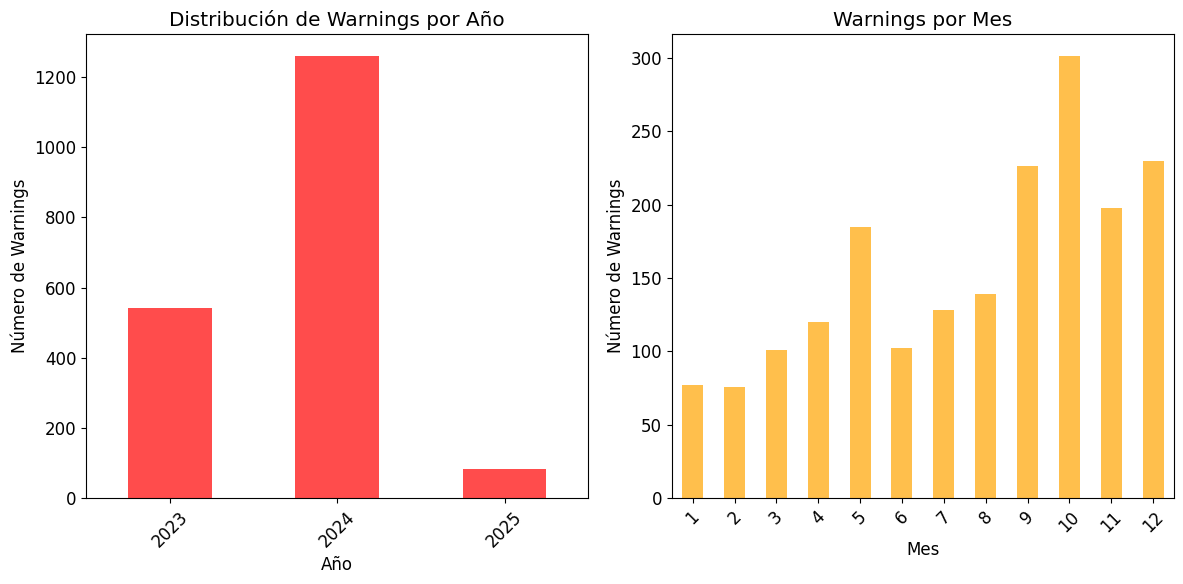

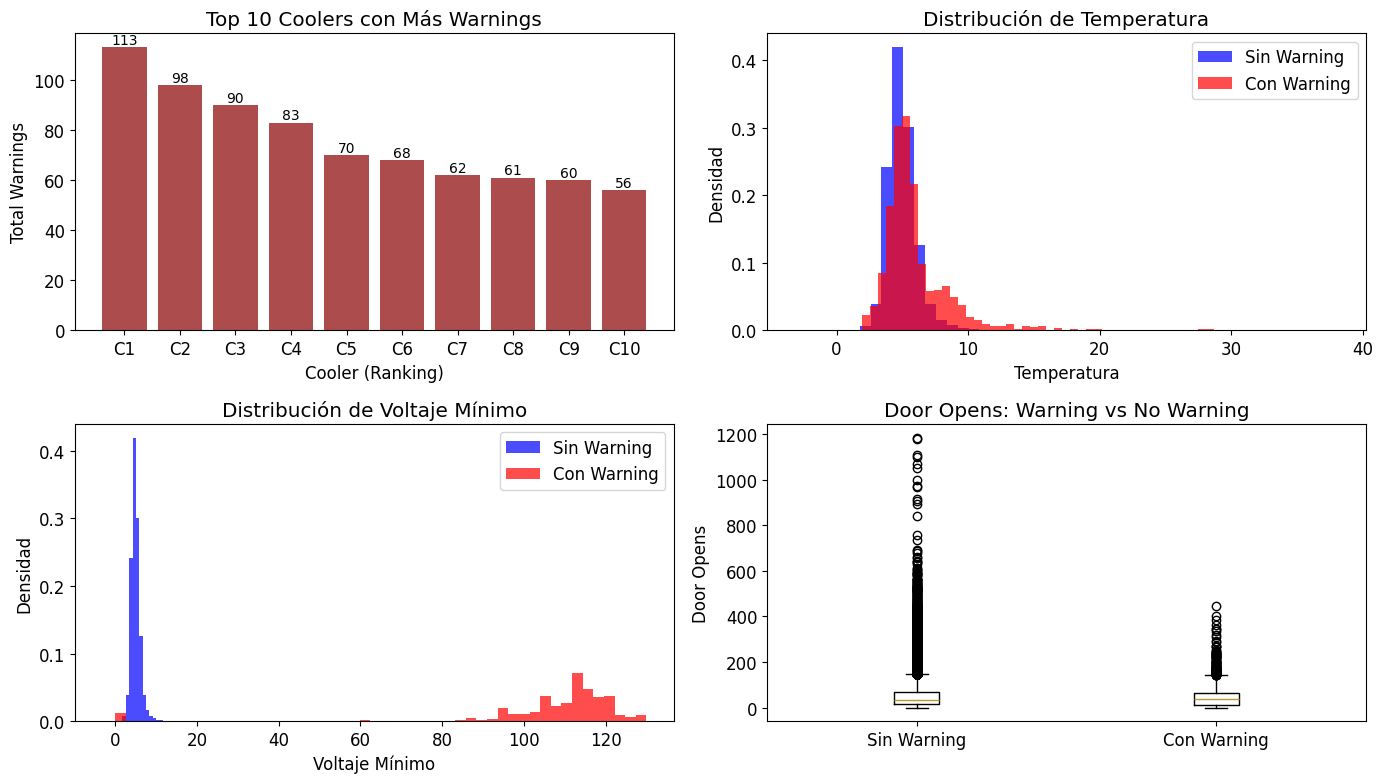

📊 Analizando Correlaciones inicial de datos...


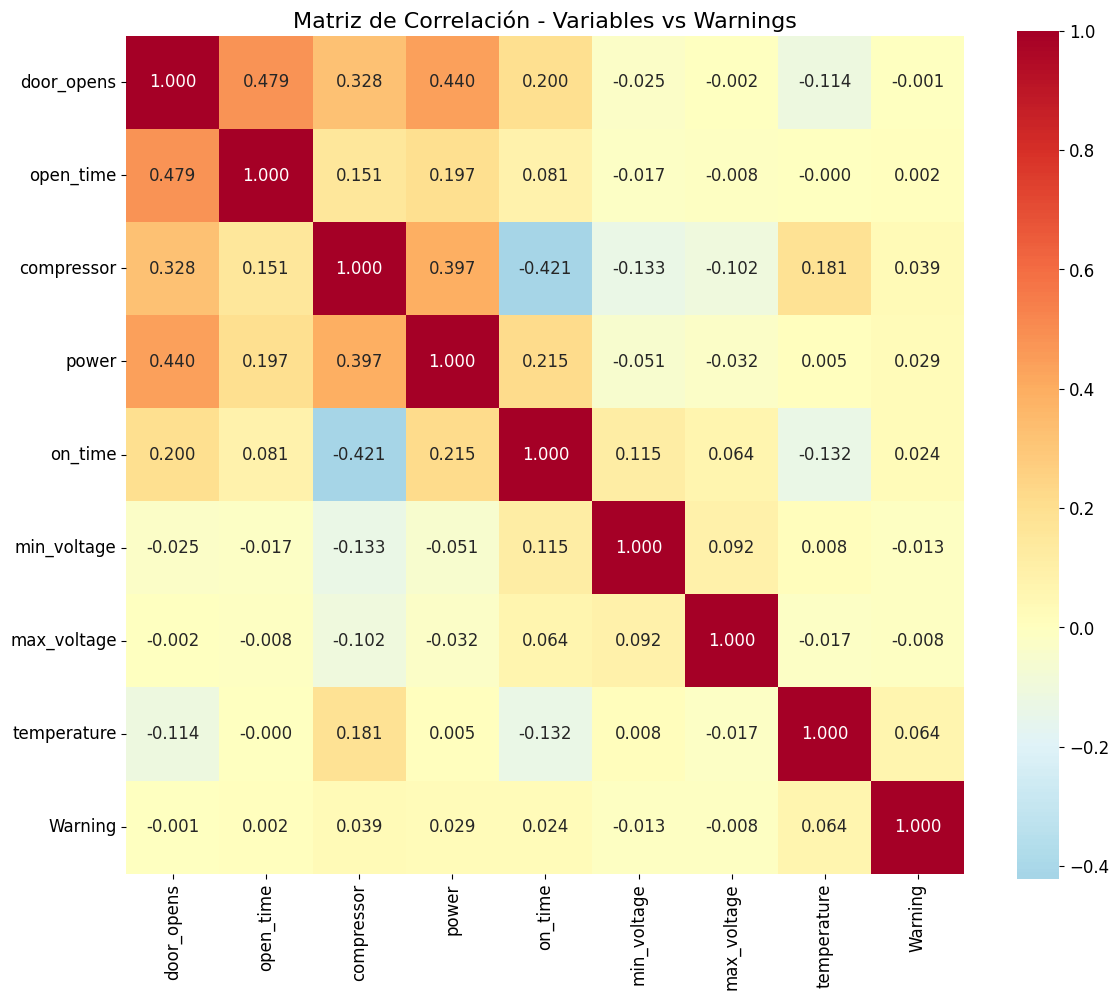

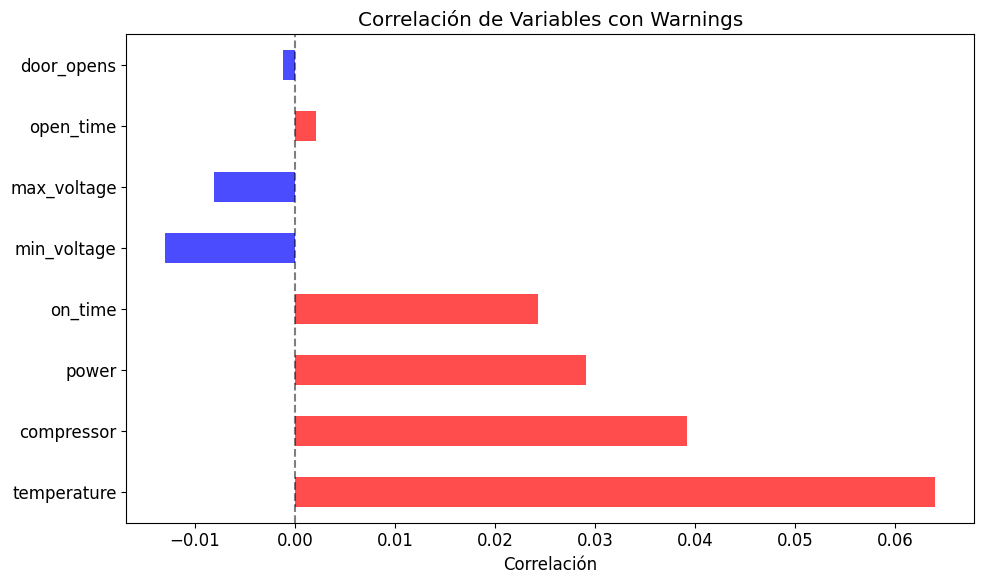

💰 Analizando Ventas...


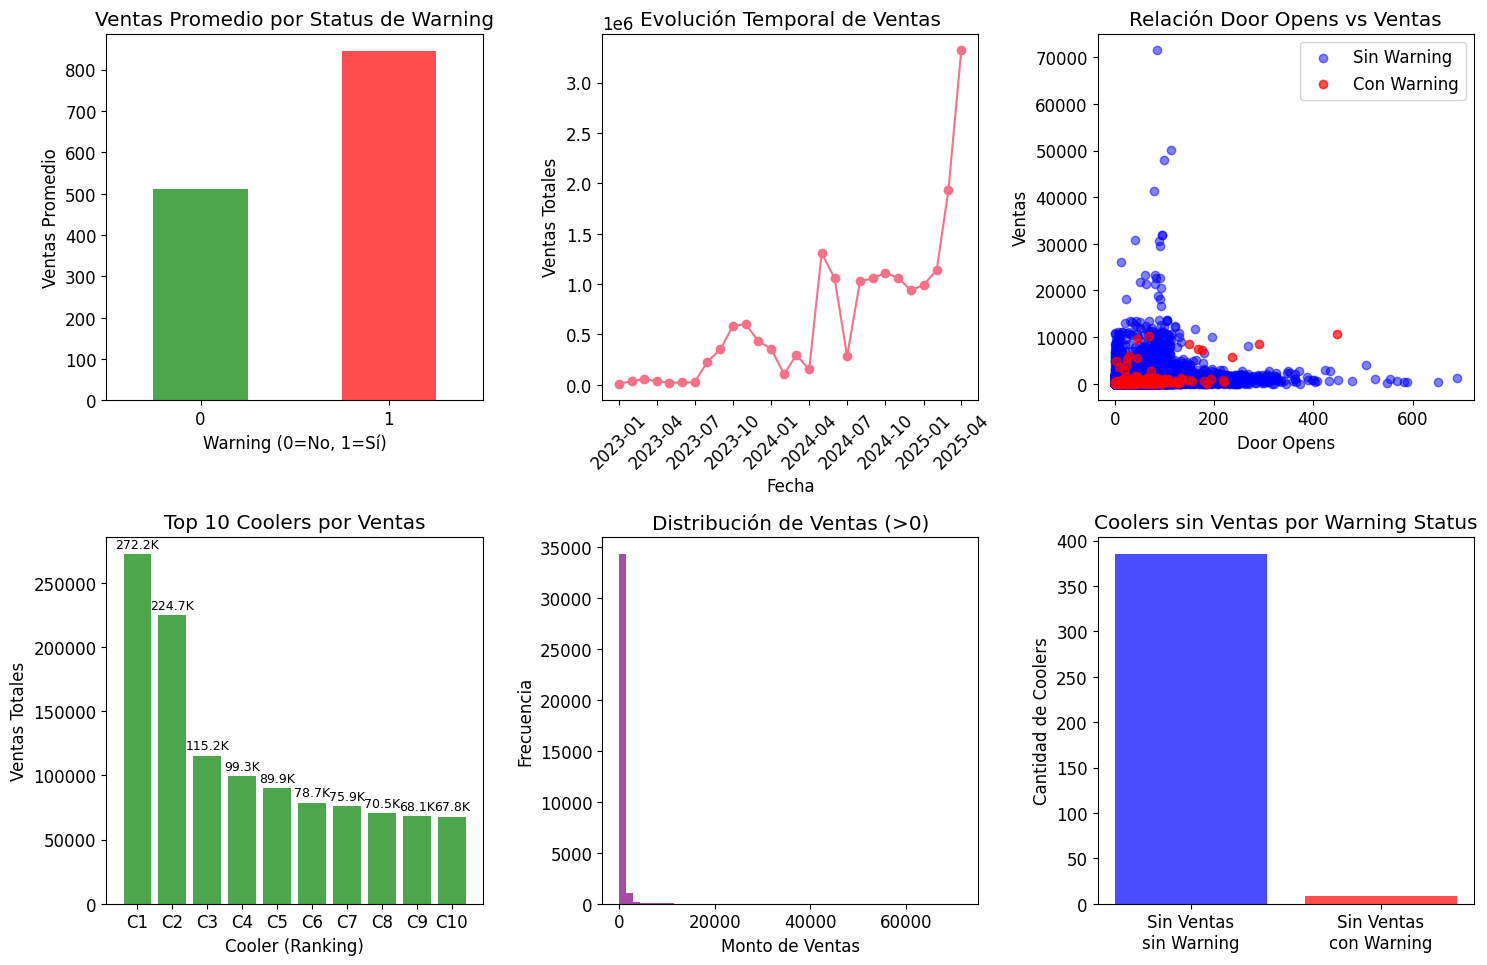

🤖 Métricas del Modelo...


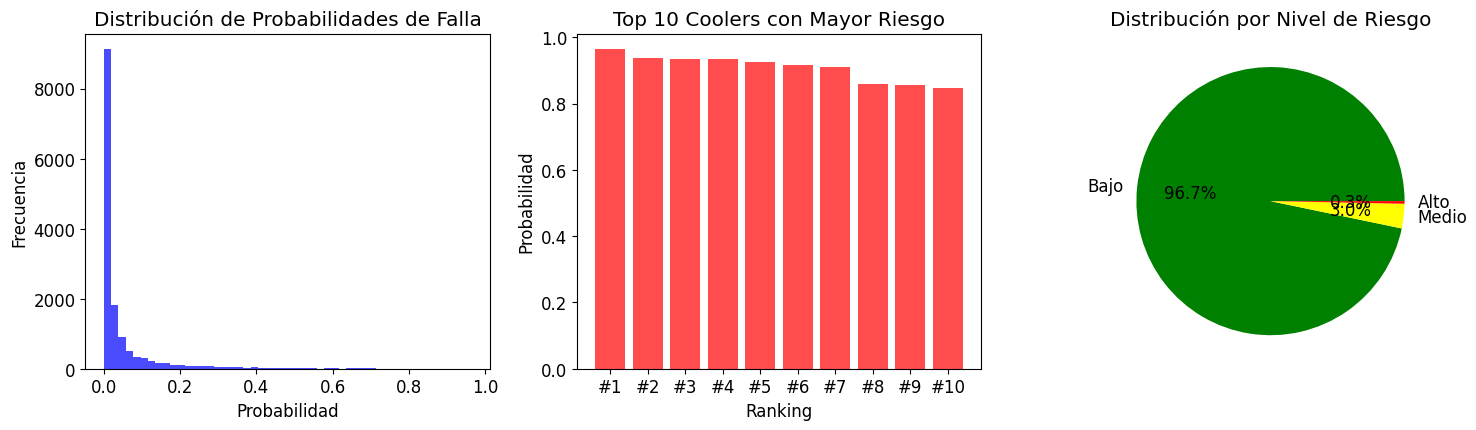

✅ Análisis Completo Finalizado!

Archivos generados:
- warnings_temporal.png
- distribucion_variables.png
- matriz_correlacion.png
- correlacion_warnings.png
- analisis_ventas.png
- metricas_modelo.png

📁 CSVs generados para entregables:
- cooler_statistics.csv (estadísticas por cooler)
- temporal_analysis.csv (análisis temporal)
- top_problematic_coolers.csv (coolers más problemáticos)
- cleaned_data.csv (dataframe limpio para modelo)


In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# ======================
# 1. CARGA DE DATOS PARA ANÁLISIS
# ======================
df_coolers = pd.read_csv('coolers.csv')
df_warning = pd.read_csv('warnings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_sales = pd.read_csv('sales.csv')

# Aplicar la misma limpieza que en tu modelo
df_coolers = df_coolers.dropna(subset=['door_opens', 'open_time', 'temperature', 'min_voltage'])
df_coolers = df_coolers[~((df_coolers['min_voltage'] == 0) & (df_coolers['max_voltage'] == 0))]

# Merge de warnings
df_warning['Warning'] = 1
df = pd.merge(df_coolers, df_warning, on='cooler_id', how='left')
df['Warning'] = df['Warning'].fillna(0).astype(int)

# Preparar fechas
df_calendar['calday'] = df_calendar['calday'].astype(str)
df['calday'] = df['calday'].astype(str)
df = df.merge(df_calendar.rename(columns={'day': 'week_day'}), on='calday', how='left')
df['date'] = pd.to_datetime(df['calday'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ======================
# 2. GRÁFICAS DE EDA (EXPLORATORY DATA ANALYSIS)
# ======================

def crear_graficas_eda():
    """Crea todas las gráficas para el análisis exploratorio"""
    
    # 1. Distribución de Warnings por Año
    plt.figure(figsize=(12, 6))
    warnings_by_year = df.groupby('year')['Warning'].sum()
    plt.subplot(1, 2, 1)
    warnings_by_year.plot(kind='bar', color='red', alpha=0.7)
    plt.title('Distribución de Warnings por Año')
    plt.xlabel('Año')
    plt.ylabel('Número de Warnings')
    plt.xticks(rotation=45)
    
    # 2. Warnings por Mes
    plt.subplot(1, 2, 2)
    warnings_by_month = df.groupby('month')['Warning'].sum()
    warnings_by_month.plot(kind='bar', color='orange', alpha=0.7)
    plt.title('Warnings por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Número de Warnings')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('warnings_temporal.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Top 10 Coolers con más Warnings
    plt.figure(figsize=(14, 8))
    top_coolers = df.groupby('cooler_id')['Warning'].sum().sort_values(ascending=False).head(10)
    plt.subplot(2, 2, 1)
    
    # Crear etiquetas más cortas para los coolers
    cooler_labels = [f"C{i+1}" for i in range(len(top_coolers))]
    
    bars = plt.bar(range(len(top_coolers)), top_coolers.values, color='darkred', alpha=0.7)
    plt.title('Top 10 Coolers con Más Warnings')
    plt.xlabel('Cooler (Ranking)')
    plt.ylabel('Total Warnings')
    plt.xticks(range(len(top_coolers)), cooler_labels, rotation=0)
    
    # Agregar valores encima de las barras
    for i, (bar, value) in enumerate(zip(bars, top_coolers.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(int(value)), ha='center', va='bottom', fontsize=10)
    
    # 4. Distribución de Temperatura
    plt.subplot(2, 2, 2)
    df_no_warning = df[df['Warning'] == 0]['temperature']
    df_warning = df[df['Warning'] == 1]['temperature']
    
    plt.hist(df_no_warning, bins=50, alpha=0.7, label='Sin Warning', color='blue', density=True)
    plt.hist(df_warning, bins=50, alpha=0.7, label='Con Warning', color='red', density=True)
    plt.title('Distribución de Temperatura')
    plt.xlabel('Temperatura')
    plt.ylabel('Densidad')
    plt.legend()
    
    # 5. Voltaje Mínimo vs Warnings
    plt.subplot(2, 2, 3)
    plt.hist(df_no_warning, bins=50, alpha=0.7, label='Sin Warning', color='blue', density=True)
    plt.hist(df[df['Warning'] == 1]['min_voltage'], bins=50, alpha=0.7, label='Con Warning', color='red', density=True)
    plt.title('Distribución de Voltaje Mínimo')
    plt.xlabel('Voltaje Mínimo')
    plt.ylabel('Densidad')
    plt.legend()
    
    # 6. Door Opens vs Warnings
    plt.subplot(2, 2, 4)
    plt.boxplot([df[df['Warning'] == 0]['door_opens'].dropna(), 
                df[df['Warning'] == 1]['door_opens'].dropna()], 
               labels=['Sin Warning', 'Con Warning'])
    plt.title('Door Opens: Warning vs No Warning')
    plt.ylabel('Door Opens')
    
    plt.tight_layout()
    plt.savefig('distribucion_variables.png', dpi=300, bbox_inches='tight')
    plt.show()

def analisis_correlaciones():
    """Análisis de correlaciones entre variables"""
    
    # Crear dataset numérico para correlaciones
    numeric_cols = ['door_opens', 'open_time', 'compressor', 'power', 'on_time', 
                   'min_voltage', 'max_voltage', 'temperature', 'Warning']
    df_corr = df[numeric_cols].copy()
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_corr.corr()
    
    # Heatmap de correlaciones
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='RdYlBu_r', 
                center=0,
                fmt='.3f',
                square=True)
    plt.title('Matriz de Correlación - Variables vs Warnings', fontsize=16)
    plt.tight_layout()
    plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlación específica con Warning
    warning_corr = correlation_matrix['Warning'].sort_values(key=abs, ascending=False)[1:]
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if x > 0 else 'blue' for x in warning_corr.values]
    warning_corr.plot(kind='barh', color=colors, alpha=0.7)
    plt.title('Correlación de Variables con Warnings')
    plt.xlabel('Correlación')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('correlacion_warnings.png', dpi=300, bbox_inches='tight')
    plt.show()

def analisis_ventas():
    """Análisis de ventas vs warnings"""
    
    # Preparar datos de ventas
    df_sales_clean = df_sales.copy()
    df_sales_clean['calmonth'] = df_sales_clean['calmonth'].astype(str)
    df_sales_clean['year'] = df_sales_clean['calmonth'].str[:4].astype(int)
    df_sales_clean['month'] = df_sales_clean['calmonth'].str[4:6].astype(int)
    
    # Aggregate monthly data
    monthly_analysis = df.groupby(['cooler_id', 'year', 'month']).agg({
        'door_opens': 'mean',
        'open_time': 'mean',
        'temperature': 'mean',
        'Warning': 'max'
    }).reset_index()
    
    # Merge con ventas
    sales_monthly = df_sales_clean.groupby(['cooler_id', 'year', 'month'])['amount'].sum().reset_index()
    monthly_with_sales = pd.merge(monthly_analysis, sales_monthly, 
                                 on=['cooler_id', 'year', 'month'], how='left')
    monthly_with_sales['amount'] = monthly_with_sales['amount'].fillna(0)
    
    plt.figure(figsize=(15, 10))
    
    # 1. Ventas por Warning Status
    plt.subplot(2, 3, 1)
    sales_by_warning = monthly_with_sales.groupby('Warning')['amount'].mean()
    sales_by_warning.plot(kind='bar', color=['green', 'red'], alpha=0.7)
    plt.title('Ventas Promedio por Status de Warning')
    plt.xlabel('Warning (0=No, 1=Sí)')
    plt.ylabel('Ventas Promedio')
    plt.xticks(rotation=0)
    
    # 2. Evolución temporal de ventas
    plt.subplot(2, 3, 2)
    sales_evolution = monthly_with_sales.groupby(['year', 'month'])['amount'].sum().reset_index()
    sales_evolution['date'] = pd.to_datetime(sales_evolution[['year', 'month']].assign(day=1))
    plt.plot(sales_evolution['date'], sales_evolution['amount'], marker='o')
    plt.title('Evolución Temporal de Ventas')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Totales')
    plt.xticks(rotation=45)
    
    # 3. Relación Door Opens vs Ventas
    plt.subplot(2, 3, 3)
    no_warning_data = monthly_with_sales[monthly_with_sales['Warning'] == 0]
    warning_data = monthly_with_sales[monthly_with_sales['Warning'] == 1]
    
    plt.scatter(no_warning_data['door_opens'], no_warning_data['amount'], 
               alpha=0.5, label='Sin Warning', color='blue')
    plt.scatter(warning_data['door_opens'], warning_data['amount'], 
               alpha=0.7, label='Con Warning', color='red')
    plt.xlabel('Door Opens')
    plt.ylabel('Ventas')
    plt.title('Relación Door Opens vs Ventas')
    plt.legend()
    
    # 4. Top coolers por ventas
    plt.subplot(2, 3, 4)
    top_sales = monthly_with_sales.groupby('cooler_id')['amount'].sum().sort_values(ascending=False).head(10)
    
    # Crear etiquetas más cortas
    sales_labels = [f"C{i+1}" for i in range(len(top_sales))]
    
    bars = plt.bar(range(len(top_sales)), top_sales.values, color='green', alpha=0.7)
    plt.title('Top 10 Coolers por Ventas')
    plt.xlabel('Cooler (Ranking)')
    plt.ylabel('Ventas Totales')
    plt.xticks(range(len(top_sales)), sales_labels, rotation=0)
    
    # Agregar valores encima de las barras (formato abreviado)
    for i, (bar, value) in enumerate(zip(bars, top_sales.values)):
        if value >= 1000:
            label = f"{value/1000:.1f}K"
        else:
            label = f"{int(value)}"
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_sales.values)*0.01, 
                label, ha='center', va='bottom', fontsize=9)
    
    # 5. Distribución de ventas
    plt.subplot(2, 3, 5)
    plt.hist(monthly_with_sales[monthly_with_sales['amount'] > 0]['amount'], 
             bins=50, alpha=0.7, color='purple')
    plt.title('Distribución de Ventas (>0)')
    plt.xlabel('Monto de Ventas')
    plt.ylabel('Frecuencia')
    
    # 6. Coolers sin ventas vs con warnings
    plt.subplot(2, 3, 6)
    no_sales = monthly_with_sales[monthly_with_sales['amount'] == 0]
    warning_no_sales = no_sales['Warning'].sum()
    total_no_sales = len(no_sales)
    
    plt.bar(['Sin Ventas\nsin Warning', 'Sin Ventas\ncon Warning'], 
            [total_no_sales - warning_no_sales, warning_no_sales],
            color=['blue', 'red'], alpha=0.7)
    plt.title('Coolers sin Ventas por Warning Status')
    plt.ylabel('Cantidad de Coolers')
    
    plt.tight_layout()
    plt.savefig('analisis_ventas.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return monthly_with_sales

def metricas_modelo():
    """Crear gráficas de métricas del modelo"""
    # Cargar resultados del modelo
    try:
        pred_results = pd.read_csv('predicted_warnings_may2025.csv')
        
        plt.figure(figsize=(15, 8))
        
        # 1. Distribución de probabilidades
        plt.subplot(2, 3, 1)
        plt.hist(pred_results['probability'], bins=50, alpha=0.7, color='blue')
        plt.title('Distribución de Probabilidades de Falla')
        plt.xlabel('Probabilidad')
        plt.ylabel('Frecuencia')
        
        # 2. Top coolers con mayor riesgo
        plt.subplot(2, 3, 2)
        top_risk = pred_results.nlargest(10, 'probability')
        plt.bar(range(len(top_risk)), top_risk['probability'], color='red', alpha=0.7)
        plt.title('Top 10 Coolers con Mayor Riesgo')
        plt.xlabel('Ranking')
        plt.ylabel('Probabilidad')
        plt.xticks(range(len(top_risk)), [f'#{i+1}' for i in range(len(top_risk))])
        
        # 3. Categorización por riesgo
        plt.subplot(2, 3, 3)
        pred_results['risk_category'] = pd.cut(pred_results['probability'], 
                                             bins=[0, 0.3, 0.7, 1.0], 
                                             labels=['Bajo', 'Medio', 'Alto'])
        risk_counts = pred_results['risk_category'].value_counts()
        plt.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
                colors=['green', 'yellow', 'red'])
        plt.title('Distribución por Nivel de Riesgo')
        
        plt.tight_layout()
        plt.savefig('metricas_modelo.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return pred_results
        
    except FileNotFoundError:
        print("Archivo predicted_warnings_may2025.csv no encontrado. Ejecuta primero el modelo.")
        return None

# ======================
# 3. FUNCIÓN PRINCIPAL PARA EJECUTAR TODO
# ======================

def ejecutar_analisis_completo():
    """Ejecuta todo el análisis y genera todas las gráficas"""
    
    print("🔍 Iniciando Análisis Exploratorio de Datos...")
    crear_graficas_eda()
    
    print("📊 Analizando Correlaciones inicial de datos...")
    analisis_correlaciones()
    
    print("💰 Analizando Ventas...")
    monthly_data = analisis_ventas()
    
    print("🤖 Métricas del Modelo...")
    pred_data = metricas_modelo()

    
    print("✅ Análisis Completo Finalizado!")
    print("\nArchivos generados:")
    print("- warnings_temporal.png")
    print("- distribucion_variables.png") 
    print("- matriz_correlacion.png")
    print("- correlacion_warnings.png")
    print("- analisis_ventas.png")
    print("- metricas_modelo.png")
    
    return monthly_data, pred_data

# ======================
# 4. GENERAR CSVs PARA ENTREGABLES
# ======================

def generar_csvs_entregables():
    """Genera los CSVs necesarios para la presentación"""
    
    # 1. Estadísticas por cooler
    cooler_stats = df.groupby('cooler_id').agg({
        'door_opens': ['mean', 'std'],
        'open_time': ['mean', 'std'],
        'temperature': ['mean', 'std'], 
        'min_voltage': ['mean', 'std'],
        'power': ['mean', 'std'],
        'Warning': ['sum', 'count']
    }).round(4)
    
    cooler_stats.columns = ['_'.join(col).strip() for col in cooler_stats.columns]
    cooler_stats['warning_rate'] = (cooler_stats['Warning_sum'] / cooler_stats['Warning_count'] * 100).round(2)
    cooler_stats.reset_index().to_csv('cooler_statistics.csv', index=False)
    
    # 2. Análisis temporal
    temporal_analysis = df.groupby(['year', 'month']).agg({
        'cooler_id': 'nunique',
        'Warning': 'sum',
        'door_opens': 'mean',
        'temperature': 'mean',
        'power': 'mean'
    }).round(4)
    temporal_analysis.reset_index().to_csv('temporal_analysis.csv', index=False)
    
    # 3. Top coolers problemáticos
    problematic_coolers = df.groupby('cooler_id')['Warning'].sum().sort_values(ascending=False)
    top_problematic = df[df['cooler_id'].isin(problematic_coolers.head(20).index)]
    top_problematic_stats = top_problematic.groupby('cooler_id').agg({
        'door_opens': 'mean',
        'open_time': 'mean', 
        'temperature': 'mean',
        'min_voltage': 'mean',
        'Warning': 'sum'
    }).round(4)
    top_problematic_stats.reset_index().to_csv('top_problematic_coolers.csv', index=False)

    # 4. dataframe limpio y listo para el modelo
    monthly.to_csv('cleaned_data.csv', index=False)
    
    print("\n📁 CSVs generados para entregables:")
    print("- cooler_statistics.csv (estadísticas por cooler)")
    print("- temporal_analysis.csv (análisis temporal)")
    print("- top_problematic_coolers.csv (coolers más problemáticos)")
    print("- cleaned_data.csv (dataframe limpio para modelo)")

# Ejecutar todo el análisis
if __name__ == "__main__":
    monthly_data, predictions = ejecutar_analisis_completo()
    generar_csvs_entregables()

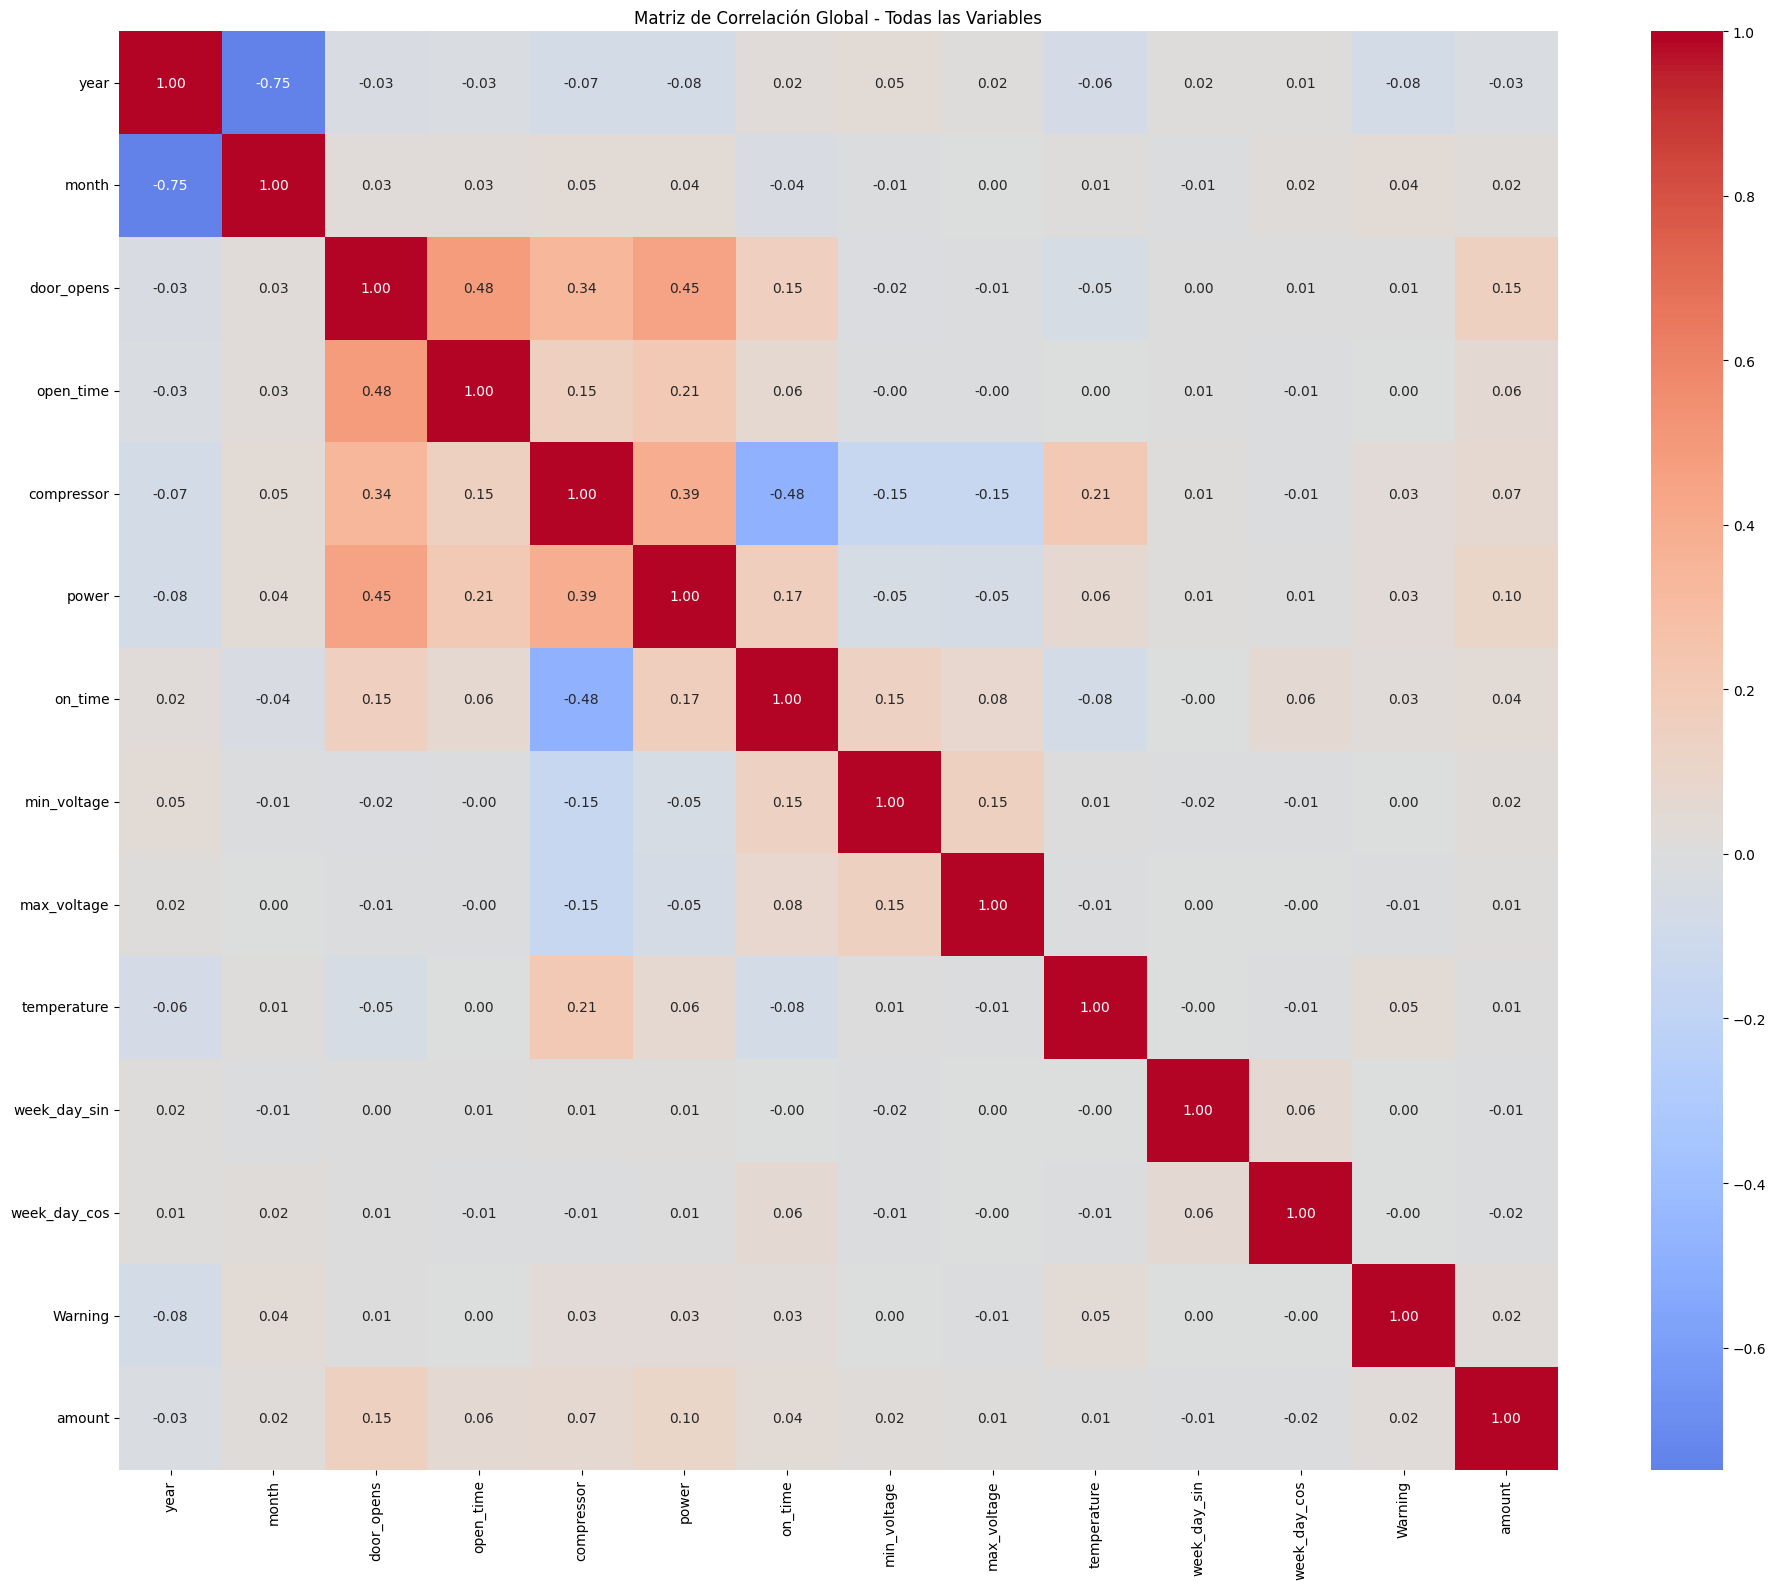

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Matriz de Correlación Global con todas las características
def matriz_correlacion_completa(df):
    """
    Crea una matriz de correlación usando todas las variables numéricas del dataset
    """
    # Seleccionamos solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    
    # Creamos una figura más grande para acomodar todas las variables
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, 
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f',
                square=True,
                xticklabels=True,
                yticklabels=True)
    
    plt.title('Matriz de Correlación Global - Todas las Variables')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Llamas la función
matriz_correlacion_completa(monthly)